### Import Suite Client

In [1]:
import spb.sdk
# ~/.spb/config must exist
print(f'This guide was made with this version: v{spb.sdk.__version__}')

This guide was made with this version: v0.2.11


### Import Pachyderm Client

In [2]:
import python_pachyderm
# ~/.pachyderm/config.json must exist
pachyderm_client = python_pachyderm.Client.new_from_config()

### Read Suite Project

* We'll use sample project from the Suite
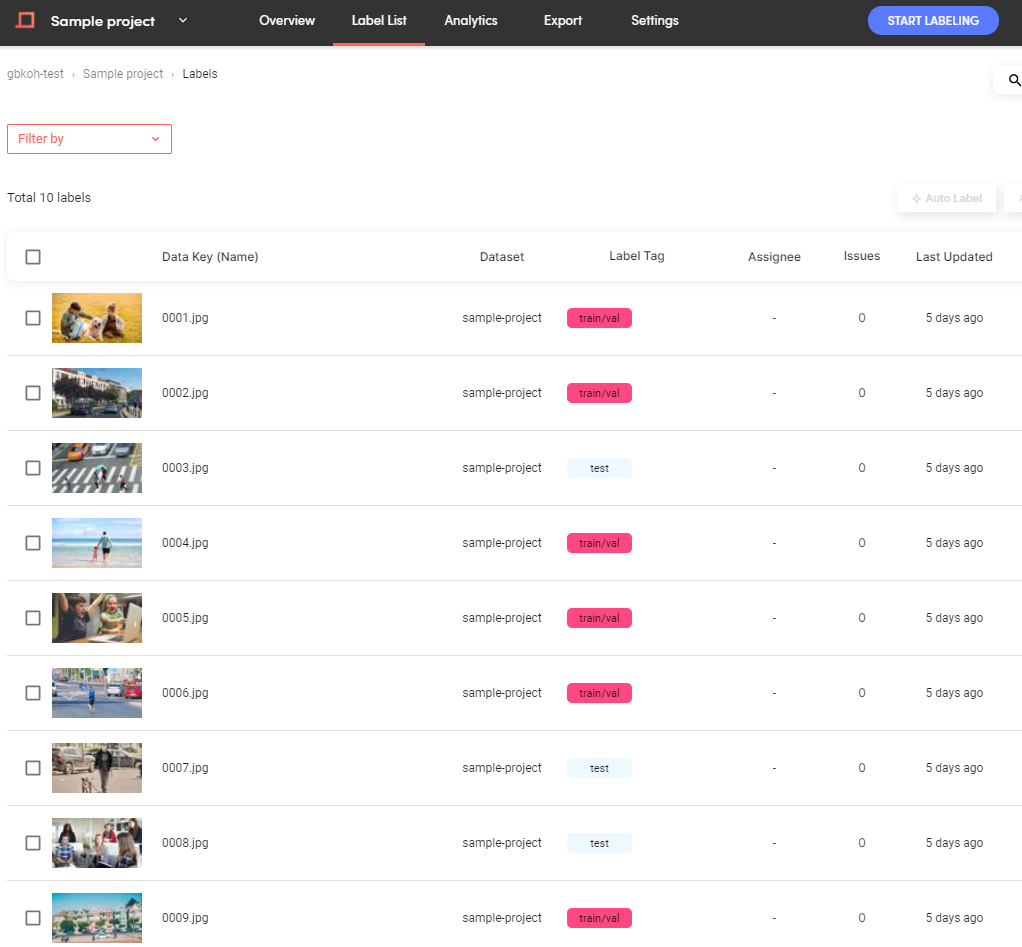

In [3]:
spb_client = spb.sdk.Client(project_name='Sample Project')

# Print project information
print('Project Name: {}'.format(spb_client.get_project_name()))
print('Total number of data: {}'.format(spb_client.get_num_data()))

Project Name: Sample project
Total number of data: 10


### Prepare Pachyderm Repo

In [4]:
pachyderm_client.create_repo('sample_project')

* Created pachyderm repository
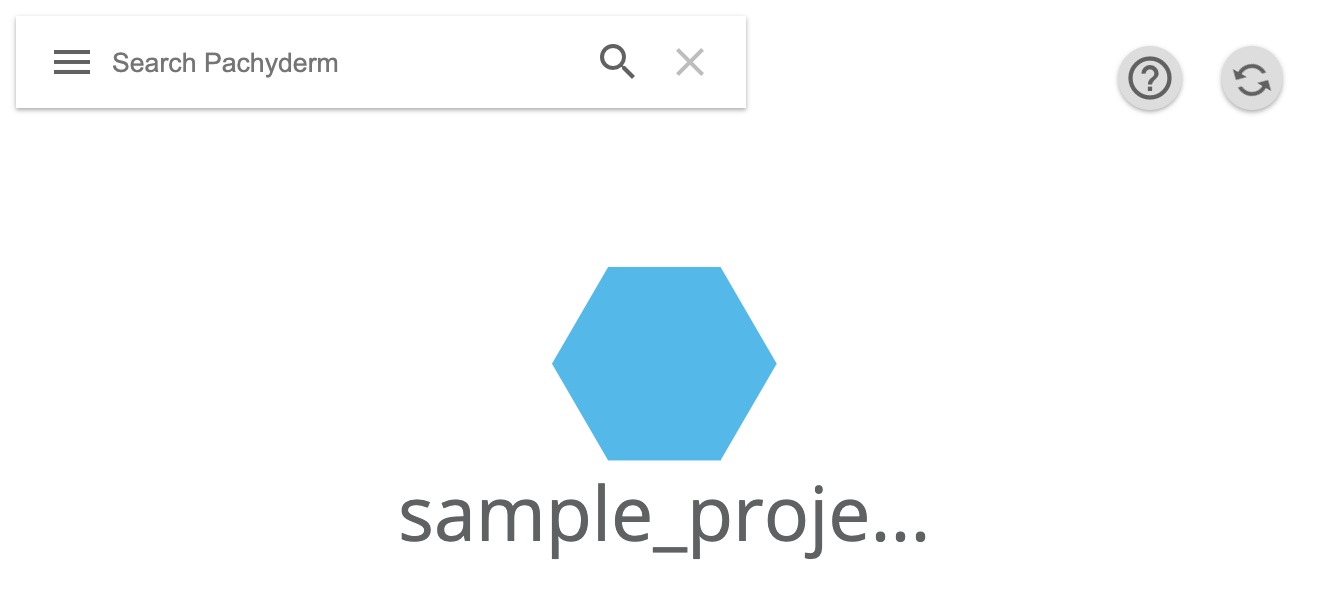

### Assiging Colors to Classes

In [5]:
class_objects = spb_client._project.label_interface['objects']
colors = [
    (229, 115, 115),
    (240, 98, 146),
    (186, 104, 200),
    (149, 117, 205),
    (121, 134, 203),
    (100, 181, 246),
    (79, 195, 247),
    (77, 208, 225),
    (77, 182, 172),
    (129, 199, 132),
    (174, 213, 129),
    (220, 231, 117),
    (255, 241, 118),
    (255, 213, 79),
    (255, 183, 77),
    (255, 138, 101),
    (161, 136, 127)
]

class_to_color = {}
for idx, class_object in enumerate(class_objects):
    color_idx = idx % 17
    class_to_color[class_object['name']] = colors[color_idx]

### Upload Suite Data to Pachyderm

In [6]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imghdr

# Iterate all data
def get_spb_data(client, page_size=10):
    num_data = client.get_num_data()
    print(f'# of images: {num_data}')
    num_page = (num_data + page_size - 1) // page_size
    for page_idx in range(num_page):
        for data_handler in client.get_data_page(page_idx=page_idx, page_size=page_size):
            yield data_handler

with pachyderm_client.commit('sample_project', 'v1') as c:
    for data_handler in get_spb_data(spb_client):
        dataset = data_handler.get_dataset_name()
        data_key = data_handler.get_key()
        imghdr = data_key.split('.')[-1]
        rendered_key = data_key.split('.')[0] + '_rendered.' + imghdr

        image_url = data_handler.get_image_url()
        label = {
            'objects': data_handler.get_object_labels(),
            'categories': data_handler.get_category_labels()
        }
        image = data_handler.get_image()
        for obj in label['objects']:
            class_name = obj['class']
            if 'box' in obj['shape']:
                box = obj['shape']['box']
                pt1 = (int(box['x']), int(box['y']))
                pt2 = (int(box['x'] + box['width']), int(box['y'] + box['height']))
                cv2.rectangle(image, pt1, pt2, class_to_color[class_name], 3)
                cv2.putText(image, class_name, (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, class_to_color[class_name], 2)
            elif 'polygon' in obj['shape']:
                polygon_list = obj['shape']['polygon']
                polygon = np.array([[int(pt['x']), int(pt['y'])] for pt in polygon_list], np.int32)
                minx, miny = min([p[0] for p in polygon]), min([p[1] for p in polygon])
                cv2.polylines(image, [polygon], True, class_to_color[class_name], thickness=3)
                cv2.putText(image, class_name, (minx, miny - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, class_to_color[class_name], 2)
        img_str = cv2.imencode(f'.{imghdr}', image[:,:,::-1])[1].tostring()
        pachyderm_client.put_file_url(c, f'{dataset}/{data_key}', image_url)
        pachyderm_client.put_file_bytes(c, f'{dataset}/{rendered_key}', img_str)
        pachyderm_client.put_file_bytes(c, f'{dataset}/{data_key}.json', json.dumps(label).encode('utf-8'))


# of images: 10


/home/jhlee/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


* Uploaded files
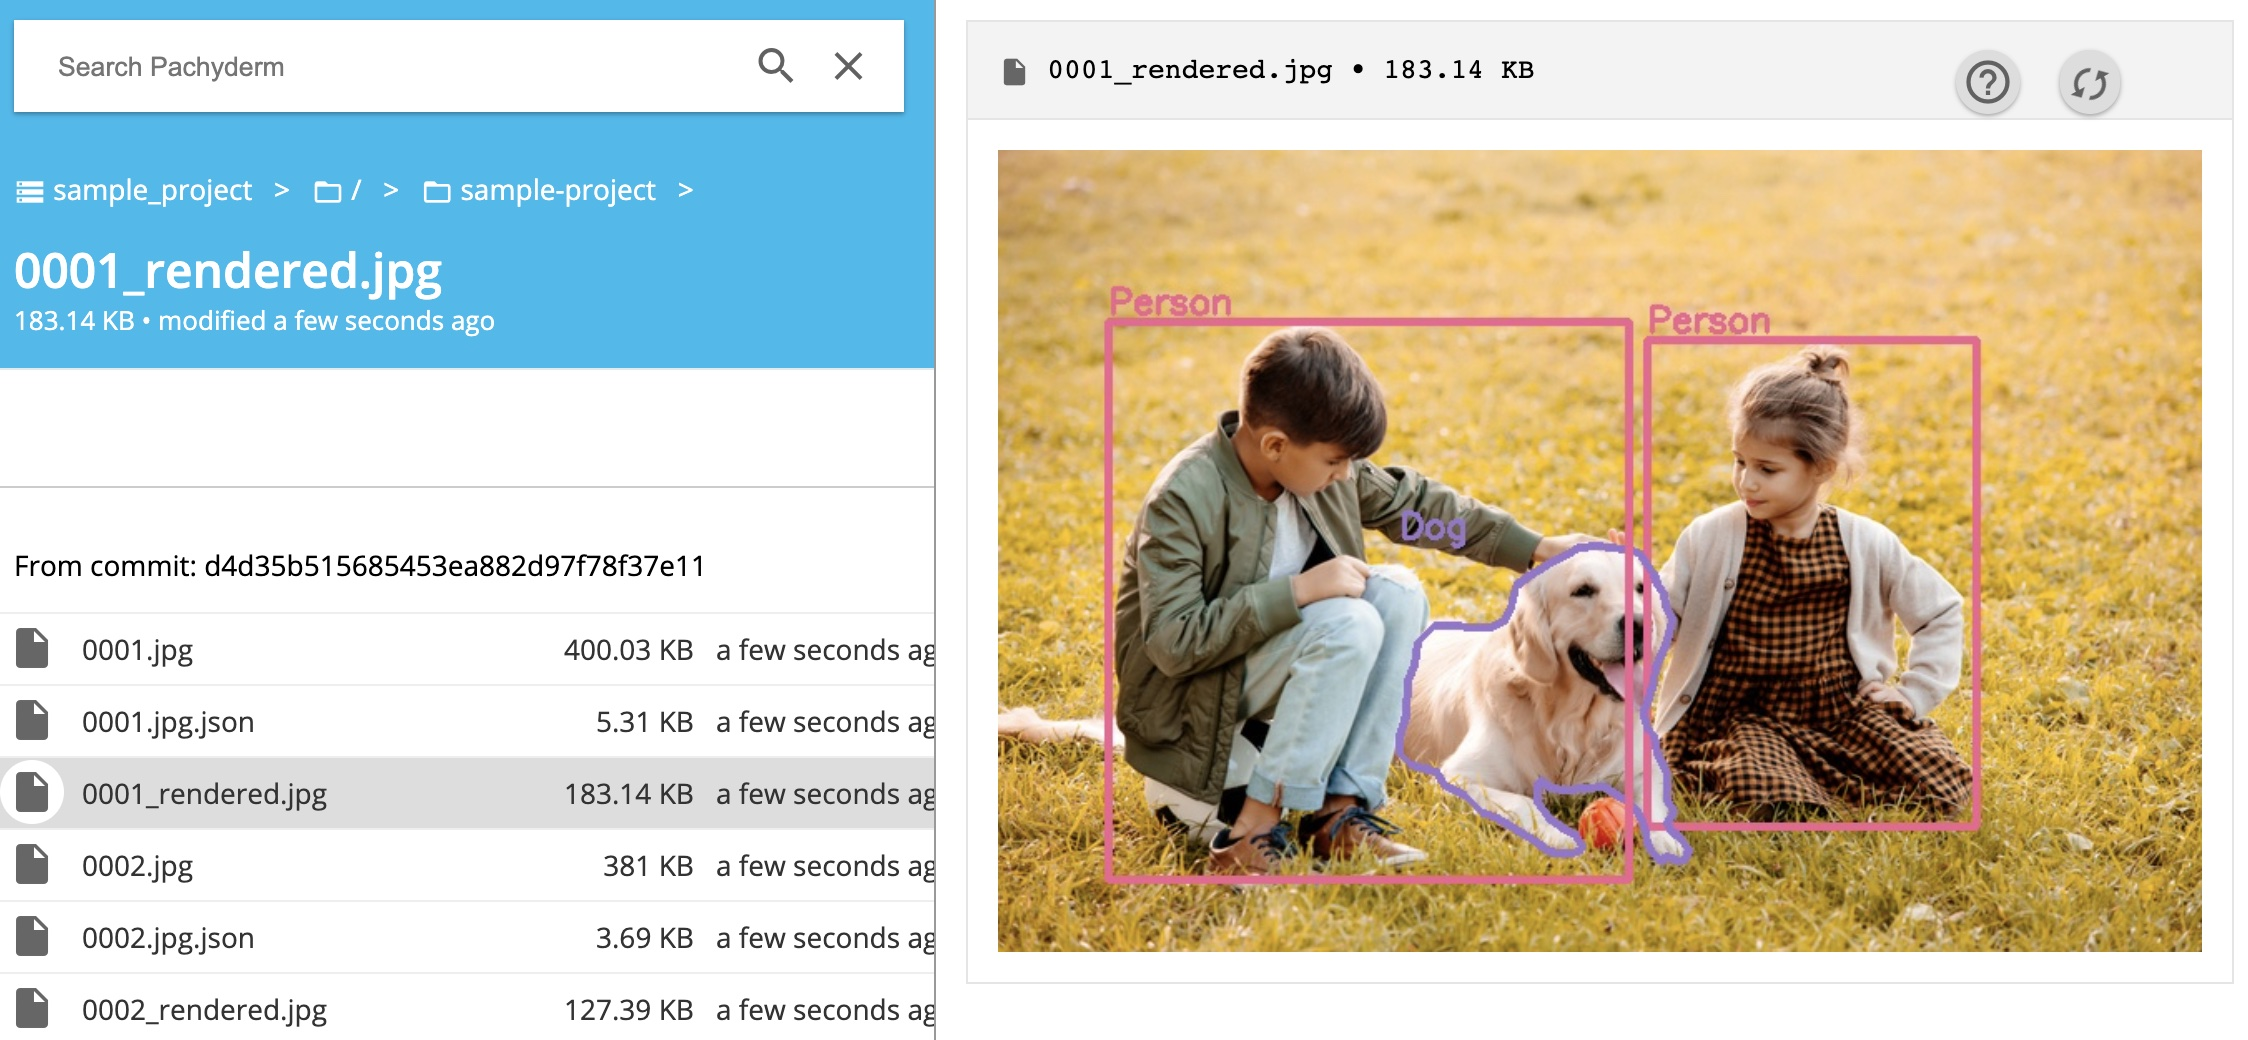